In [1]:
from kdg import kdf
from kdg.utils import generate_gaussian_parity, plot_2dsim
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import numpy as np

### Visualize the data
The data is bounded within [-1,1] limit.

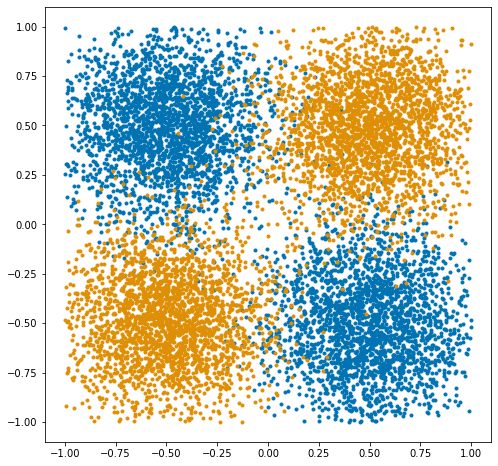

In [2]:
X, y = generate_gaussian_parity(10000)
plot_2dsim(X, y)

### Define the model with one tree

In [3]:
def experiment(sample):
    X, y = generate_gaussian_parity(sample, cluster_std=0.5)
    X_test, y_test = generate_gaussian_parity(1000, cluster_std=0.5)
    
    model_kdf = kdf(kwargs={'n_estimators':1})
    model_kdf.fit(X, y)

    error_kdf = 1 - np.mean(model_kdf.predict(X_test)==y_test)
    error_rf = 1 - np.mean(model_kdf.rf_model.predict(X_test)==y_test)

    return error_kdf, error_rf

In [4]:
mc_reps = 50
sample_size = np.logspace(
        np.log10(10),
        np.log10(50000),
        num=10,
        endpoint=True,
        dtype=int
)

In [5]:
err_rf_med = []
err_rf_25_quantile = []
err_rf_75_quantile = []

err_kdf_med = []
err_kdf_25_quantile = []
err_kdf_75_quantile = []
for sample in sample_size:
    print('Doing sample %d'%sample)

    res_kdf = Parallel(n_jobs=-1)(
                delayed(experiment)(
                sample
                ) for _ in range(mc_reps)
            )

    err_kdf = []
    err_rf = []

    for ii in range(mc_reps):
        err_kdf.append(
                res_kdf[ii][0]
            )
        err_rf.append(
                res_kdf[ii][1]
            )

    err_rf_med.append(np.median(err_rf))
    err_rf_25_quantile.append(
            np.quantile(err_rf,[.25])[0]
        )
    err_rf_75_quantile.append(
        np.quantile(err_rf,[.75])[0]
    )
    err_kdf_med.append(np.median(err_kdf))
    err_kdf_25_quantile.append(
            np.quantile(err_kdf,[.25])[0]
        )
    err_kdf_75_quantile.append(
        np.quantile(err_kdf,[.75])[0]
    )

Doing sample 10
Doing sample 25
Doing sample 66
Doing sample 170
Doing sample 440
Doing sample 1134
Doing sample 2924
Doing sample 7533
Doing sample 19407
Doing sample 49999


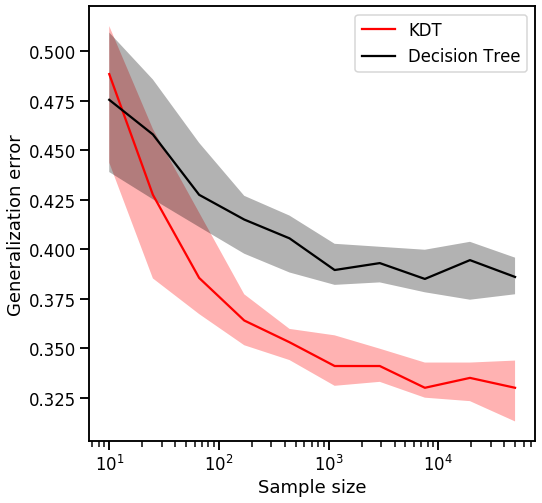

In [8]:
sns.set_context('talk')
fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.plot(sample_size, err_kdf_med, c="r", label='KDT')
ax.plot(sample_size, err_rf_med, c="k", label='Decision Tree')

ax.fill_between(sample_size, err_kdf_25_quantile, err_kdf_75_quantile, facecolor='r', alpha=.3)
ax.fill_between(sample_size, err_rf_25_quantile, err_rf_75_quantile, facecolor='k', alpha=.3)

ax.set_xscale('log')
ax.set_xlabel('Sample size')
ax.set_ylabel('Generalization error')
ax.legend()

In [1]:
from __future__ import print_function
import enum
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10, mnist
from tensorflow.keras import backend as k
import numpy as np
from kdg import kdcnn
import os

import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [74]:
network = keras.models.load_model('mnist_test')
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_test -= x_train_mean
    
inp = network.input
test_image = x_test[:2]
outputs = []

for layer in network.layers:  
    if 'activation' in layer.name:
        print(layer.name)
        outputs.append(layer.output)
    
functor = K.function(inp, outputs )   # evaluation function

# Testing
test = x_test[:2].reshape(-1,28,28,1)
layer_outs = functor(test)
print(layer_outs[4])
 

activation
activation_1
activation_2
activation_3
activation_4
activation_5
[[[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]

  [[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.00463158 0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]

  [[0.         0.         0.         ... 0.         0.

In [65]:
network.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 20, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 20, 20, 64)        0     

In [32]:
outputs

[<KerasTensor: shape=(None, 24, 24, 32) dtype=float32 (created by layer 'activation')>,
 <KerasTensor: shape=(None, 20, 20, 64) dtype=float32 (created by layer 'activation_1')>,
 <KerasTensor: shape=(None, 16, 16, 96) dtype=float32 (created by layer 'activation_2')>,
 <KerasTensor: shape=(None, 12, 12, 128) dtype=float32 (created by layer 'activation_3')>,
 <KerasTensor: shape=(None, 8, 8, 160) dtype=float32 (created by layer 'activation_4')>,
 <KerasTensor: shape=(None, 10240) dtype=float32 (created by layer 'activation_5')>]

In [33]:
len(layer_outs)

6

In [42]:
(layer_outs[0]>.5).astype('int').reshape(-1).shape

(36864,)

In [43]:
layer_outs[0].shape

(2, 24, 24, 32)

In [70]:
activation = []
for layer_out in layer_outs:
    activation.append(
        list((layer_out>.5).astype('int').reshape(2,-1))
    )

In [71]:
activation

[[array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])],
 [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 1, 0, 0])],
 [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])],
 [array([0, 0, 0, ..., 0, 0, 0]), array([0, 1, 0, ..., 0, 0, 0])],
 [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])],
 [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]]

In [30]:
polytope_ids = np.concatenate(activation, axis=1)

In [31]:
polytope_ids

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [32]:
a = layer_outs[0].reshape(-1)

In [33]:
np.where(a>0)[0]

array([ 2368,  2373,  2374, ..., 35994, 35998, 35999])

In [34]:
unique_polytope_ids, polytope_samples_ = np.unique(polytope_ids, return_counts=True, axis=0)

In [35]:
unique_polytope_ids

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [8]:
polytope_samples_

array([1, 1])

In [9]:
matched_pattern = (polytope_ids==polytope_ids[0] & polytope_ids[0])

In [10]:
matched_pattern

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [21]:
np.where(matched_pattern[1]==False)

(array([   160,    165,    166, ..., 107314, 107329, 107352]),)

In [40]:
pol = polytope_ids[0]

In [41]:
pol[np.where(pol == 0)[0]] = 2

In [42]:
pol

array([2, 2, 2, ..., 2, 2, 2])

In [43]:
(polytope_ids==pol)

array([[ True,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False]])

In [48]:
polytope_ids

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [62]:
polytope_ids[0][-1]

0

In [73]:
np.where(activation[4][1]==1)

(array([], dtype=int64),)

In [72]:
np.where(polytope_ids[0][87040:87040+10240])

(array([    1,     3,     7, ..., 10236, 10238, 10239]),)